In [29]:
#
# Created on Mon Jan 18 19:51:29 2016
#
# @author: jrose01
# Adapted by: mcolosso
#

In [30]:
%matplotlib inline

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

#pd.set_option('display.float_format', lambda x:'%.3f'%x)
#pd.set_option('display.mpl_style', 'default')   # --deprecated
#plt.style.use('ggplot')   # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [31]:
#
# DATA MANAGEMENT
#

In [32]:
#Load the dataset

loans = pd.read_csv("./LendingClub.csv", low_memory = False)

# LendingClub.csv is a dataset taken from The LendingClub (https://www.lendingclub.com/)
# which is a peer-to-peer leading company that directly connects borrowers and potential
# lenders/investors

In [33]:
#
# Exploring the target column
#

In [34]:
# The target column (label column) of the dataset that we are interested in is called
# `bad_loans`. In this column 1 means a risky (bad) loan and 0 means a safe loan.
#
# In order to make this more intuitive, we reassign the target to be:
# 1 as a safe loan and 0 as a risky (bad) loan. 
#
# We put this in a new column called `safe_loans`.

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : 1 if x == 0 else 0)
loans.drop('bad_loans', axis = 1, inplace = True)

In [35]:
# Select features to handle

# In this oportunity, we are going to ignore 'grade' and 'sub_grade' predictors
# assuming those are a way to "clustering" the loans

predictors = ['short_emp',                 # one year or less of employment
              'emp_length_num',            # number of years of employment
              'home_ownership',            # home_ownership status: own, mortgage or rent
              'dti',                       # debt to income ratio
              'purpose',                   # the purpose of the loan
              'term',                      # the term of the loan
              'last_delinq_none',          # has borrower had a delinquincy
              'last_major_derog_none',     # has borrower had 90 day or worse rating
              'revol_util',                # percent of available credit being used
              'total_rec_late_fee',        # total late fees received to day
             ]

target     =  'safe_loans'                 # prediction target (y) (+1 means safe, 0 is risky)

ignored    = ['grade',                     # grade of the loan
              'sub_grade',                 # sub-grade of the loan
             ]

# Extract the predictors and target columns
loans = loans[predictors + ignored + [target]]

# Delete rows where any or all of the data are missing
loans = loans.dropna()

In [36]:
# Convert categorical text variables into numerical ones

categorical = ['home_ownership', 'purpose', 'term', 'grade', 'sub_grade']
for attr in categorical:
    attributes_list = list(set(loans[attr]))
#    print('{}:'.format(attr), list(enumerate(attributes_list)))
    loans[attr] = [attributes_list.index(idx) for idx in loans[attr] ]

In [37]:
(loans.describe()).T

,count,mean,std,min,25%,50%,75%,max
short_emp,122607.0,0.123672,0.329208,0.0,0.00,0.00,0.00,1.00
emp_length_num,122607.0,6.370256,3.736014,0.0,3.00,6.00,11.00,11.00
home_ownership,122607.0,0.954024,0.959780,0.0,0.00,1.00,2.00,3.00
dti,122607.0,15.496888,7.497442,0.0,9.88,15.26,20.85,39.88
purpose,122607.0,4.449085,1.891378,0.0,4.00,5.00,5.00,11.00
term,122607.0,0.797679,0.401732,0.0,1.00,1.00,1.00,1.00
last_delinq_none,122607.0,0.588115,0.492177,0.0,0.00,1.00,1.00,1.00
last_major_derog_none,122607.0,0.873906,0.331957,0.0,1.00,1.00,1.00,1.00
revol_util,122607.0,53.716307,25.723881,0.0,34.80,55.70,74.30,150.70
total_rec_late_fee,122607.0,0.742344,5.363268,0.0,0.00,0.00,0.00,208.82


In [38]:
#
# MODELING AND PREDICTION
#

In [39]:
# Standardize clustering variables to have mean=0 and sd=1

for attr in predictors:
    loans[attr] = preprocessing.scale(loans[attr].astype('float64'))

In [40]:
# Split data into train and test sets

clus_train, clus_test = train_test_split(loans[predictors], test_size = .3, random_state = 123)

In [41]:
# K-means cluster analysis for 1-9 clusters                                                           

from scipy.spatial.distance import cdist
clusters = range(1,10)
meandist = list()

for k in clusters:
    model = KMeans(n_clusters = k).fit(clus_train)
    clusassign = model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
                    / clus_train.shape[0])

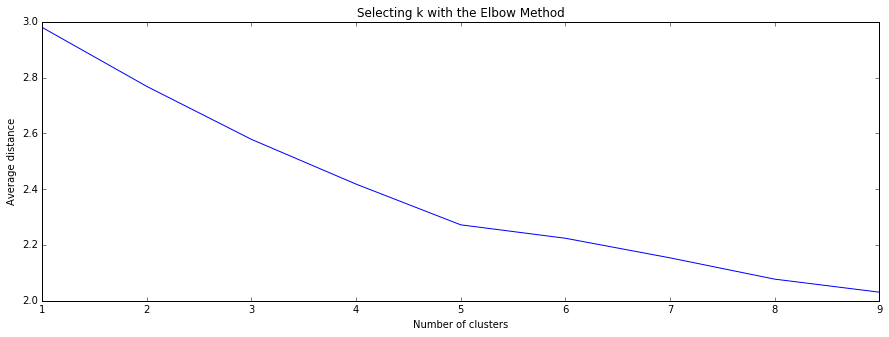

In [42]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

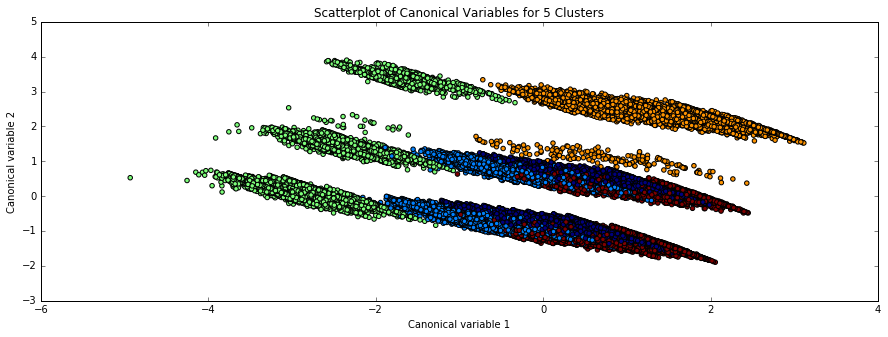

In [44]:
# Interpret 5 cluster solution
model = KMeans(n_clusters = 5).fit(clus_train)
clusassign = model.predict(clus_train)

# Plot clusters
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x = plot_columns[:, 0], y = plot_columns[:, 1], c = model.labels_, )
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 5 Clusters')
plt.show()

In [16]:
#
# BEGIN multiple steps to merge cluster assignment with clustering variables to examine
# cluster variable means by cluster
#

In [17]:
# Create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level = 0, inplace = True)

# Create a list that has the new index variable
cluslist = list(clus_train['index'])

# Create a list of cluster assignments
labels = list(model.labels_)

In [18]:
# Combine index variable list with cluster assignment list into a dictionary
newlist = dict(zip(cluslist, labels))
#newlist

In [19]:
# Convert newlist dictionary to a dataframe
newclus = DataFrame.from_dict(newlist, orient = 'index')
#newclus

In [20]:
# Rename the cluster assignment column
newclus.columns = ['cluster']

In [21]:
# Now do the same for the cluster assignment variable:

# Create a unique identifier variable from the index for the cluster assignment
# dataframe to merge with cluster training data
newclus.reset_index(level = 0, inplace = True)

# Merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train = pd.merge(clus_train, newclus, on = 'index')
merged_train.head(n = 100)
# cluster frequencies
merged_train.cluster.value_counts()

1    35171
3    29585
2    10369
4     9617
0     1082
Name: cluster, dtype: int64

In [22]:
#
# END multiple steps to merge cluster assignment with clustering variables to examine
# cluster variable means by cluster
#

In [23]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
         index  short_emp  emp_length_num  home_ownership       dti   purpose  \
cluster                                                                         
0        47583   0.062289       -0.146602        0.065236 -0.091828 -0.071299   
1        60446  -0.375666        0.418487       -0.913814  0.018670 -0.032648   
2        58923   2.661942       -1.510308        0.251683 -0.073279 -0.035926   
3        58039  -0.375666       -0.075256        1.013215 -0.002504  0.053860   
4        78966  -0.375666        0.364002       -0.082756  0.049572  0.015512   

             term  last_delinq_none  last_major_derog_none  revol_util  \
cluster                                                                  
0       -0.119834         -0.175276               0.226724    0.199589   
1       -0.135829          0.121339               0.379852   -0.023362   
2        0.134885          0.079915               0.064633   -0.074889   
3        0.132995        

In [24]:
# Validate clusters in training data by examining cluster differences in SAFE_LOANS using ANOVA
# first have to merge SAFE_LOANS with clustering variables and cluster assignment data 
gpa_data = loans['safe_loans']

# split safe_loans data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1 = pd.DataFrame(gpa_train)
gpa_train1.reset_index(level = 0, inplace = True)
merged_train_all = pd.merge(gpa_train1, merged_train, on = 'index')
sub1 = merged_train_all[['safe_loans', 'cluster']].dropna()

In [25]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

gpamod = smf.ols(formula = 'safe_loans ~ C(cluster)', data = sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:             safe_loans   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     311.0
Date:                Thu, 07 Jul 2016   Prob (F-statistic):          4.12e-266
Time:                        22:48:23   Log-Likelihood:                -40776.
No. Observations:               85824   AIC:                         8.156e+04
Df Residuals:                   85819   BIC:                         8.161e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.4325      0.012     

In [26]:
print ('Means for SAFE_LOANS by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

Means for SAFE_LOANS by cluster
         safe_loans
cluster            
0          0.432532
1          0.836257
2          0.793519
3          0.795910
4          0.821566


In [27]:
print ('Standard deviations for SAFE_LOANS by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

Standard deviations for SAFE_LOANS by cluster
         safe_loans
cluster            
0          0.495656
1          0.370047
2          0.404799
3          0.403042
4          0.382898


In [28]:
mc1 = multi.MultiComparison(sub1['safe_loans'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     0.4037   0.371   0.4365  True 
  0      2     0.361    0.3271  0.3949  True 
  0      3     0.3634   0.3305  0.3962  True 
  0      4     0.389    0.355   0.4231  True 
  1      2    -0.0427  -0.0546 -0.0309  True 
  1      3    -0.0403  -0.0487  -0.032  True 
  1      4    -0.0147  -0.0269 -0.0025  True 
  2      3     0.0024  -0.0097  0.0145 False 
  2      4     0.028    0.013   0.0431  True 
  3      4     0.0257   0.0132  0.0381  True 
---------------------------------------------
